# 네거티브 샘플링을 이용한 Word2Vec 구현 <br>(Skip-gram with Negative Sampling, SGNS)

## 1. 네거티브 샘플링(Negative Sampling)

- Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만 <br> 만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이, '귀여운'과 같은 단어라면 <br> 사실 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적이다. <br><br>

- 네거티브 샘플링은 Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법이다.
- 현재 집중하고 있는 주변 단어가 '고양이', '귀여운' 일 때, <br> '돈가스', '컴퓨터', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져온다. <br> 이렇게 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어놓고 마지막 단계를 이진 분류 문제로 변환한다.
- 주변 단어들을 긍정(positive), 랜덤으로 샘플링된 단어들은 부정(negative)으로 레이블링 한다면 이진 분류를 위한 데이터 set이 된다.
- 이는 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적이다.

## 2. 네거티브 샘플링 Skip-Gram

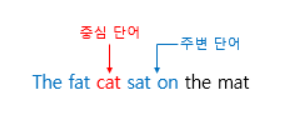

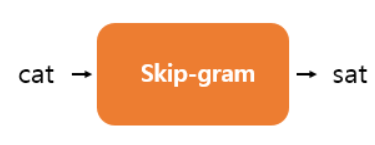

- Skip-gram은 중심 단어를 통해 주변 단어를 예측하는 모델. <br><br>

- 하지만 네거티브 샘플링을 사용하는 Skip-gram 인 SGNS는 이와는 다른 접근 방식을 취한다.
- SGNS는 다음과 같이 중심 단어와 주변 단어가 모두 입력이 되고, 이 두 단어가 실제로 윈도우 크기 내에 존재하는 이웃 관계인지 그 확률을 예측한다.

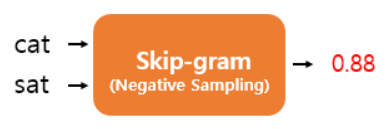

### 기존의 Skip-gram 데이터 셋을 SGNS의 데이터 셋으로 바꾸는 과정

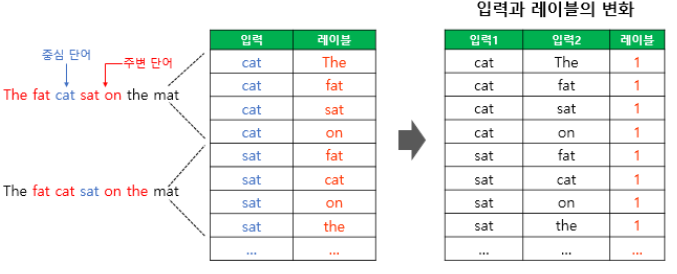

- 우선, 기존의 Skip-gram 데이터 셋에서 중심 단어와 주변 단어를 가각 입력1, 입력2로 둔다. <br> 이 둘은 실제로 윈도우 크기 내에서 이웃 관계였으므로 레이블은 1로 한다.

<br><br>

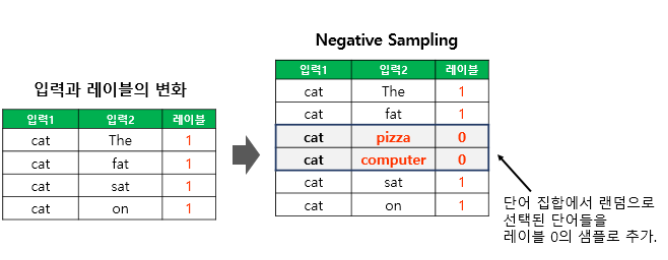

- 이제 레이블이 0인 샘플들을 준비할 차례이다.
- 실제로는 입력1(중심 단어)와 주변 단어 관계가 아닌 단어들을 입력2로 삼기 위해서 단어 집합에서 랜덤으로 선택한 단어들을 입력2로 하고, 레이블을 0으로 한다.

<br><br>

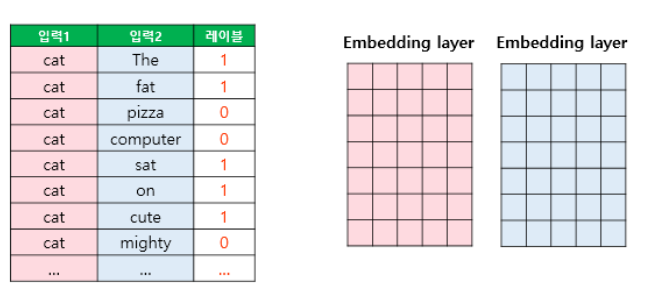

- 이제 두 개의 임베딩 테이블을 준비한다. <br> 두 임베딩 테이블은 훈련 데이터의 단어 집합의 크기를 가지므로 크기가 같다.
- 두 테이블 중 하나는 입력 1인 중심 단어의 테이블 룩업을 위한 임베딩 테이블이고 <br>다른 하나는 입력 2인 주변 단어의 테이블 룩업을 위한 임베딩 테이블이다.

<br><br>

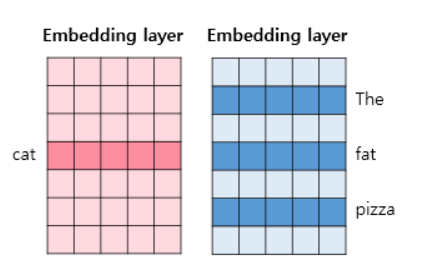

- 각 단어는 각 임베딩 테이블을 테이블 룩업하여 임베딩 벡터로 변환된다.

<br>

- 각 임베딩 테이블을 통해 테이블을 룩업하여 임베딩 벡터로 변환되었다면 그 후의 연산은 매우 간단하다.

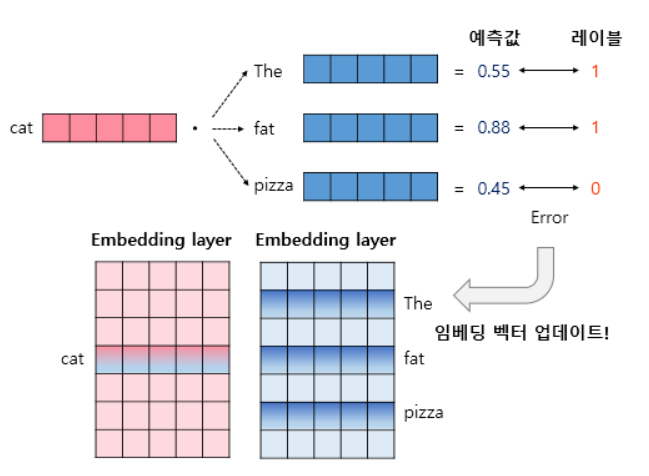

- 중심 단어와 주변 단어의 내적값을 이 모델의 예측값으로 하고, <br> 레이블과의 오차로부터 역전파하여 중심 단어와 주변 단어의 임베딩 벡터값을 업데이트한다.
- 이후에는 선택적으로 두 개의 임베딩 테이블 중 좌측의 테이블을 최종 임베딩 테이블로 사용할 수 있다.

## 3. 20 뉴스그룹 데이터 전처리하기

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [4]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, 
                             remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [5]:
news_df = pd.DataFrame({'document':documents})

# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")

# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-5-8f133937e839>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [6]:
# 현재 데이터 프레임에 NULL 값이 있는지 확인
news_df.isnull().values.any()

False

In [7]:
# Empty Value 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [8]:
# NULL값을 제거
news_df.dropna(inplace=True)
print('총 샘플 수 : ', len(news_df))

총 샘플 수 :  10995


In [9]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

- 불용어를 제거하였으므로 단어의 수가 줄어 듦.
- 모든 샘플 중 단어가 1개 이하인 경우를 모두 찾아 제거

In [10]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


C:\Users\hoon9\AppData\Roaming\Python\Python38\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


- 단어 집합을 생성하고, 정수 인코딩을 진행

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [13]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


## 4. 네거티브 샘플링을 통한 데이터 셋 구성하기

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [38]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
print(skip_grams[0])
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

([[702, 207], [634, 43323], [1920, 149], [1036, 31448], [1148, 9117], [581, 1920], [1148, 1036], [661, 37452], [6, 702], [1979, 15228], [70, 34929], [1920, 30069], [4988, 40985], [4521, 957], [1979, 23736], [4521, 2393], [70, 6173], [87, 705], [442, 35404], [4865, 984], [1979, 87], [702, 15227], [59, 474], [87, 13686], [1920, 7837], [51, 957], [207, 1495], [442, 32300], [1979, 569], [755, 634], [52, 17943], [4865, 1530], [222, 60843], [1148, 1320], [51, 4295], [20294, 1979], [1102, 51], [4866, 15310], [442, 661], [10668, 29812], [1530, 217], [1102, 52], [4406, 55055], [217, 15228], [52, 42785], [228, 4521], [10669, 33747], [4295, 42933], [1495, 15227], [661, 581], [442, 474], [20294, 1095], [442, 228], [581, 1191], [5533, 56682], [702, 1148], [984, 43593], [603, 32088], [442, 2485], [581, 12768], [4520, 702], [149, 21069], [705, 10355], [70, 59209], [7837, 31064], [702, 4294], [207, 15227], [207, 1530], [1495, 63753], [68, 66], [5533, 29119], [149, 4988], [702, 4294], [5533, 20294], [4

In [16]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [17]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [18]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

## 5. Skip-gram with Negative Sampling(SGNS) 구현

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [25]:
embed_size = 100 # hyper param

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

print(f'vocab_size: {vocab_size}, embed_size: {embed_size}')

vocab_size: 64277, embed_size: 100


- 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고 <br> 내적의 결과는 1 또는 0 을 예측하기 위해서 Sigmoid 함수를 거쳐 최종 예측값을 얻는다.

In [26]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

In [27]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 100)       6427700     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 100)       6427700     input_12[0][0]                   
______________________________________________________________________________________________

In [28]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4634.312054904178
Epoch : 2 Loss : 3650.827395655215
Epoch : 3 Loss : 3480.7034999616444
Epoch : 4 Loss : 3286.2527367323637
Epoch : 5 Loss : 3066.8620260320604


## 6. 결과 확인하기

In [30]:
import gensim

- 학습된 임베딩 벡터들을 vector.txt에 저장

In [31]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 이를 gensim의 .models.KeyedVectors.load_word2vec_format로 로드하면 쉽게 단어 간 유사도를 구할 수 있습니다.

In [32]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [33]:
w2v.most_similar(positive=['soldiers'])

[('massacred', 0.8788380026817322),
 ('brutally', 0.8719910383224487),
 ('wounded', 0.8682665228843689),
 ('raped', 0.8630177974700928),
 ('nazi', 0.8616238832473755),
 ('enclave', 0.8614004850387573),
 ('fighting', 0.8605157732963562),
 ('troops', 0.8559483289718628),
 ('mosque', 0.8539206385612488),
 ('terrorists', 0.8502769470214844)]

In [34]:
w2v.most_similar(positive=['doctor'])

[('symptoms', 0.6157247424125671),
 ('urgent', 0.5991513729095459),
 ('pains', 0.5911456346511841),
 ('officiating', 0.588424801826477),
 ('knife', 0.5836215019226074),
 ('patient', 0.5818721652030945),
 ('onset', 0.5813905596733093),
 ('tumor', 0.5781930088996887),
 ('jumped', 0.5676130652427673),
 ('drank', 0.5664485692977905)]

In [35]:
w2v.most_similar(positive=['police'])

[('ministry', 0.6899681687355042),
 ('federal', 0.6852430701255798),
 ('attacking', 0.6832630634307861),
 ('committee', 0.6673886775970459),
 ('enclave', 0.6594240069389343),
 ('crook', 0.6589450240135193),
 ('notwithstanding', 0.6560541391372681),
 ('administration', 0.6552882790565491),
 ('officers', 0.6520603895187378),
 ('deported', 0.650044322013855)]

In [36]:
w2v.most_similar(positive=['knife'])

[('stephanopoulos', 0.7800471186637878),
 ('janet', 0.7765714526176453),
 ('massacre', 0.7698444724082947),
 ('assault', 0.7673218250274658),
 ('attacked', 0.7608262896537781),
 ('fulfilled', 0.7581925988197327),
 ('prefers', 0.7562657594680786),
 ('assad', 0.7562112808227539),
 ('iraqi', 0.7526591420173645),
 ('sabra', 0.7516363263130188)]

In [37]:
w2v.most_similar(positive=['engine'])

[('tires', 0.792661190032959),
 ('brakes', 0.7457489371299744),
 ('torque', 0.7036845684051514),
 ('wheels', 0.7000182867050171),
 ('liter', 0.6882243752479553),
 ('toyota', 0.6872138381004333),
 ('pipe', 0.6832555532455444),
 ('racing', 0.681617796421051),
 ('rear', 0.6793126463890076),
 ('integra', 0.6738359332084656)]